# 1. Dataset and features description

The aim of this analysis is to find some patterns, relationship, or abnormality in activity level of depressive patients

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from statsmodels.tsa.seasonal import seasonal_decompose

## Varibles description:

| Variable name | Description | Meaning of variable's values |
| ------------- | ----------- | ---------------------------- |
| timestamp     | Time of day 1-minute intervals | '%Y-%m-%d %H:%M:%S' | 
| date          | Date of measurement            | '%Y-%m-%d'          |
| activity      | Activity measurement from the actigraph watch | g/min |
|               |                                |                  |
|               |                                |                  |
| days      | number of days of measurements | number of days of measurements |
| gender    | gender of patient              | 1: female, 2: male |
| age       | age groups in years            | age in each age group |
| afftype   | depression type                | 1: bipolar II, 2: unipolar depressive, 3: bipolar I |
| melanch   | having melancholia or not      | 1: melancholia, 2: no melancholia|
| inpatient | inpatient or not               | 1: inpatient, 2: outpatient|
| edu       | education grouped in years     | education grouped in years
|marriage   | relationship status            | 1: married or cohabiting, 2: single|
| work      | working/studying status        | 1: working or studying, 2: unemployed/sick leave/pension|
| madrs1    | MADRS score(!!) when measurement started | From **0** to **60** |
| madrs2    | MADRS score(!!) when measurement stopped | From **0** to **60** |
  

(!) Movements over 0.05 g are continuously recorded (with exception of taking shower) with the sampling frequency of 32Hz to obtain activity count which is proportional to the intensity of the movement. These values are writen down on the dataset every minute.
https://datasets.simula.no/depresjon/#dataset-details

(!!) The Montgomery-Asberg Depression Rating Scale (MADRS) is used to grade the current severity of an ongoing depression [18]. Clinicians rate ten items relevant for depression based on observation and conversation with the patient,
and the sum score (0-60) state the severity of the depression. Scores below 10 are classified as absence of depressive symptoms [9], and scores above 30 indicate a severe depressive state [20].  
  
  
[18] Stuart A Montgomery and MARIE Asberg. 1979. A new depression scale designed
to be sensitive to change. The British journal of psychiatry 134, 4 (1979), 382–389.  
[9] CJ Hawley, TM Gale, and T Sivakumaran. 2002. Defining remission by cut off
score on the MADRS: selecting the optimal value. Journal of affective disorders
72, 2 (2002), 177–184.  
[20] Matthias J Müller, Hubertus Himmerich, Barbara Kienzle, and Armin Szegedi. 2003. Differentiating moderate and severe depression using the Montgomery–
Åsberg depression rating scale (MADRS). Journal of affective disorders (2003).



In [ ]:
def get_unquie_value(df):
    for col in df:
        print(f"Column {col}: {df[col].unique()} \n")

## 1.1. Score data
### Load data

In [ ]:
data_dir = "/gdrive/MyDrive/Digital_health_depression/data"
scores_df_raw =  pd.read_csv(os.path.join(data_dir, "scores.csv"))
get_unquie_value(scores_df_raw)

Column number: ['condition_1' 'condition_2' 'condition_3' 'condition_4' 'condition_5'
 'condition_6' 'condition_7' 'condition_8' 'condition_9' 'condition_10'
 'condition_11' 'condition_12' 'condition_13' 'condition_14'
 'condition_15' 'condition_16' 'condition_17' 'condition_18'
 'condition_19' 'condition_20' 'condition_21' 'condition_22'
 'condition_23' 'control_1' 'control_2' 'control_3' 'control_4'
 'control_5' 'control_6' 'control_7' 'control_8' 'control_9' 'control_10'
 'control_11' 'control_12' 'control_13' 'control_14' 'control_15'
 'control_16' 'control_17' 'control_18' 'control_19' 'control_20'
 'control_21' 'control_22' 'control_23' 'control_24' 'control_25'
 'control_26' 'control_27' 'control_28' 'control_29' 'control_30'
 'control_31' 'control_32'] 

Column days: [11 18 13  7  5  9 14 12 16  8 20] 

Column gender: [2 1] 

Column age: ['35-39' '40-44' '45-49' '25-29' '50-54' '20-24' '60-64' '55-59' '30-34'
 '65-69'] 

Column afftype: [ 2.  1.  3. nan] 

Column melanch: [ 2. 

When checking for unique values in each column, we can see that there is one column containing white space as value. Hence, to make checking for NaN values easier, we want to convert all empty spaces into NaN values.

In [ ]:
scores_df = scores_df_raw.replace(r'^\s*$', np.nan, regex=True)

In [ ]:
scores_df.set_index("number", inplace=True)
scores_df.rename(columns={"days": "total_measured_days"}, inplace=True)
scores_df.loc[:, "gender"] = scores_df.loc[:, "gender"].apply(lambda gender: {1: "female", 2: "male"}.get(gender, None))
scores_df.head()

,total_measured_days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
number,,,,,,,,,,,
condition_1,11,male,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
condition_2,18,male,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
condition_3,13,female,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
condition_4,13,male,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
condition_5,13,male,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


### Split score data into control and condition group

In [ ]:
condition_score_df_raw = scores_df[scores_df.index.str.contains("condition")]
control_score_df = scores_df[scores_df.index.str.contains("control")].loc[:, ["total_measured_days", "gender", "age"]]

#### Convert numerical data to categorical type for conditional patients



In [ ]:
condition_score_df_raw.tail(9)

,total_measured_days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
number,,,,,,,,,,,
condition_15,13,male,55-59,2.0,2.0,2.0,11-15,1.0,1.0,14.0,18.0
condition_16,16,female,45-49,2.0,2.0,2.0,11-15,1.0,2.0,13.0,17.0
condition_17,13,female,50-54,1.0,2.0,2.0,6-10,1.0,2.0,17.0,15.0
condition_18,13,male,40-44,3.0,2.0,2.0,11-15,2.0,2.0,18.0,15.0
condition_19,13,male,50-54,2.0,2.0,1.0,16-20,2.0,2.0,26.0,21.0
condition_20,13,female,30-34,2.0,1.0,1.0,6-10,1.0,2.0,27.0,25.0
condition_21,13,male,35-39,2.0,2.0,1.0,6-10,2.0,2.0,26.0,21.0
condition_22,14,female,65-69,2.0,2.0,1.0,NaN,2.0,2.0,29.0,28.0
condition_23,16,female,30-34,2.0,2.0,1.0,16-20,2.0,2.0,29.0,23.0


In [ ]:
condition_score_df = condition_score_df_raw.loc[:, ['total_measured_days', 'gender', 'age', 'edu', 'madrs1', 'madrs2']].copy()
condition_score_df.rename(columns={"edu": "total_education_years", "madrs1": "start_madrs", "madrs2": "final_madrs"}, inplace=True)

condition_score_df.loc[:, "depress_type"] = condition_score_df_raw.loc[:, "afftype"].apply(lambda afftpye: {1: "bipolar II", 2: "unipolar", 3: "bipolar I"}.get(afftpye, None))
condition_score_df.loc[:, "melancholia"] = [{1: True, 2: False}.get(melanch, None) for melanch in condition_score_df_raw.loc[:, "melanch"]]
condition_score_df.loc[:, "inpatient"] = [{1: True, 2: False}.get(inpatient, None) for inpatient in condition_score_df_raw.loc[:, "inpatient"]]
condition_score_df.loc[:, "in_relationship"] = [{1: True, 2: False}.get(marriage, None) for marriage in condition_score_df_raw.loc[:, "marriage"]]
condition_score_df.loc[:, "work_study"] = [{1: True, 2: False}.get(work, None) for work in condition_score_df_raw.loc[:, "work"]]
condition_score_df.tail(9)
#condition_score_df.describe(include='all')

,total_measured_days,gender,age,total_education_years,start_madrs,final_madrs,depress_type,melancholia,inpatient,in_relationship,work_study
number,,,,,,,,,,,
condition_15,13,male,55-59,11-15,14.0,18.0,unipolar,False,False,True,True
condition_16,16,female,45-49,11-15,13.0,17.0,unipolar,False,False,True,False
condition_17,13,female,50-54,6-10,17.0,15.0,bipolar II,False,False,True,False
condition_18,13,male,40-44,11-15,18.0,15.0,bipolar I,False,False,False,False
condition_19,13,male,50-54,16-20,26.0,21.0,unipolar,False,True,False,False
condition_20,13,female,30-34,6-10,27.0,25.0,unipolar,True,True,True,False
condition_21,13,male,35-39,6-10,26.0,21.0,unipolar,False,True,False,False
condition_22,14,female,65-69,NaN,29.0,28.0,unipolar,False,True,False,False
condition_23,16,female,30-34,16-20,29.0,23.0,unipolar,False,True,False,False


### Initial EDA (Exploratory data analysis)

In [ ]:
print("Number of condition patient is", len(condition_score_df))
print("Number of control patient is", len(control_score_df))

Number of condition patient is 23
Number of control patient is 32


In [ ]:
condition_score_df.loc[:, "total_measured_days"].describe()

count    23.000000
mean     12.652174
std       2.773391
min       5.000000
25%      12.500000
50%      13.000000
75%      14.000000
max      18.000000
Name: total_measured_days, dtype: float64

In [ ]:
control_score_df.loc[:, "total_measured_days"].describe()

count    32.000000
mean     12.562500
std       2.313181
min       8.000000
25%      13.000000
50%      13.000000
75%      13.000000
max      20.000000
Name: total_measured_days, dtype: float64

In [ ]:
scores_df["cohort"] = ["control" if "control" in patient_id else "condition" for patient_id in scores_df.index]

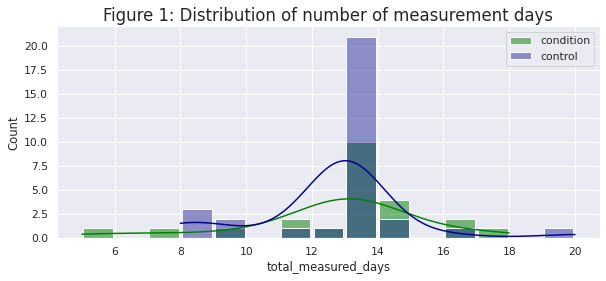

In [ ]:
plt.figure(figsize=(10, 4), dpi=70)
sns.histplot(condition_score_df["total_measured_days"], shrink=.9, binwidth=1, label="condition", color="green", stat="count", kde=True)
sns.histplot(control_score_df["total_measured_days"], shrink=.9, binwidth=1, alpha=0.4, label="control", color="darkblue", kde=True)
plt.legend()
plt.title("Figure 1: Distribution of number of measurement days", size=17)
plt.show()

In [ ]:
# plt.figure(figsize=(15,4), dpi=100)
# sns.countplot(data=scores_df_raw, x="days", hue="cohort")
# plt.yticks(range(0,22,3))
# plt.legend(loc="upper right")
# plt.title("Count for each age group", size=20)
# plt.show()

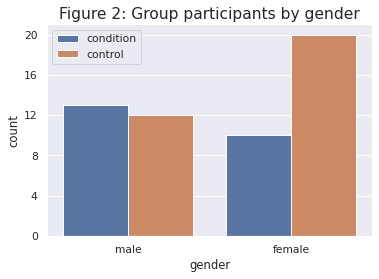

In [ ]:
plt.figure(figsize=(6, 4), dpi=70)
sns.countplot(data=scores_df, x="gender", hue="cohort")
plt.yticks(range(0,21,4))
plt.legend()
plt.title("Figure 2: Group participants by gender", size=16)
plt.show()

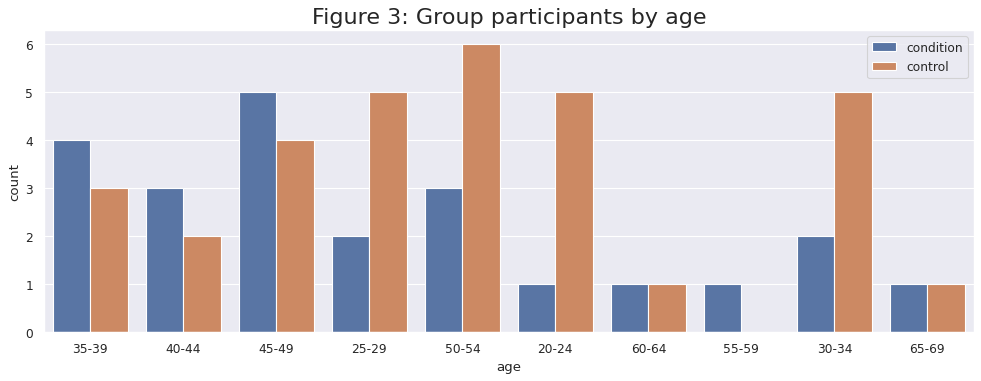

In [ ]:
plt.figure(figsize=(15, 5), dpi=80)
sns.countplot(data=scores_df, x="age", hue="cohort")
plt.legend(loc="upper right")
plt.title("Figure 3: Group participants by age", size=20)
plt.show()

In [ ]:
# common_attributes = ["days", "gender", "age"]
# condition_group_count = condition_score_df.loc[:, common_attributes].nunique()
# control_group_count = control_score_df.loc[:, common_attributes].nunique()
# fig, (day_ax, gender_ax, age_ax) = plt.subplots(1, 3, figsize=(15,5))
# day_ax box plot
# gender_ax barchart where big bar for group (2 in total), sub-bar for condition vs control
# age_ax barchart where big bar for age group(6 in total), sub-bar for condition vs control

# sns.barplot()
# gender_ax
# age_ax

### Data statistic

In [ ]:
control_score_df.describe(include="all") 

,total_measured_days,gender,age
count,32.000000,32,32
unique,NaN,2,9
top,NaN,female,50-54
freq,NaN,20,6
mean,12.562500,NaN,NaN
std,2.313181,NaN,NaN
min,8.000000,NaN,NaN
25%,13.000000,NaN,NaN
50%,13.000000,NaN,NaN
75%,13.000000,NaN,NaN


In [ ]:
condition_score_df.describe(include="all")

,total_measured_days,gender,age,total_education_years,start_madrs,final_madrs,depress_type,melancholia,inpatient,in_relationship,work_study
count,23.000000,23,23,22,23.000000,23.000000,23,20,23,23,23
unique,NaN,2,10,3,NaN,NaN,3,2,2,2,2
top,NaN,male,45-49,6-10,NaN,NaN,unipolar,False,False,False,False
freq,NaN,13,5,12,NaN,NaN,15,19,18,12,20
mean,12.652174,NaN,NaN,NaN,22.739130,20.000000,NaN,NaN,NaN,NaN,NaN
std,2.773391,NaN,NaN,NaN,4.797892,4.729021,NaN,NaN,NaN,NaN,NaN
min,5.000000,NaN,NaN,NaN,13.000000,11.000000,NaN,NaN,NaN,NaN,NaN
25%,12.500000,NaN,NaN,NaN,18.500000,16.000000,NaN,NaN,NaN,NaN,NaN
50%,13.000000,NaN,NaN,NaN,24.000000,21.000000,NaN,NaN,NaN,NaN,NaN
75%,14.000000,NaN,NaN,NaN,26.000000,24.500000,NaN,NaN,NaN,NaN,NaN


### Standardize missing values by replacing all with NaN values

In [ ]:
def check_missing_values(df):
    nan_df = df.isna().any()
    list_nan_col = df.columns[nan_df].tolist()

    # empty_string_cell_pos = np.where(df.applymap(lambda x: x.strip() == '' if isinstance(x, str) else False))
    # empty_col_index = list(set(empty_string_cell_pos[1].tolist()))
    # list_empty_col = df.columns[empty_col_index].tolist()
    # list_missing_value_col = set(list_nan_col).union(set(list_empty_col))

    if list_nan_col:
        print("Columns with missing values are:", ", ".join(list_nan_col), "where")
        for col in list_nan_col:
            print(col, "have", df[col].isna().sum(), "nan values.")
    else:
        print("Dataframe doesn't have missing values")
    print()

print("Condition:")
check_missing_values(condition_score_df)

print("Control:")
check_missing_values(control_score_df)

Condition:
Columns with missing values are: total_education_years, melancholia where
total_education_years have 1 nan values.
melancholia have 3 nan values.

Control:
Dataframe doesn't have missing values



## 1.2. Activity data
Activity data of each group of patient (condition and control) are stored in the corresponding dictionaries. Since we only have 12-day data on average, and maximumly 20 days, exact day of measurement should not matter. Hence, it might be more fruiful if we can have another variable like weekday which can then be used to analyse the daily change of activity level.

In [ ]:
def timestamp_str_to_datetime(timestamp_in_str):
    return pd.to_datetime(timestamp_in_str, infer_datetime_format=True)  # format='%Y-%m-%d %H:%M:%S'

def get_patient_data(score_df, data_dir, group_type):
    patient_dict = {}

    for patitent_id in score_df.index:
        df_activity = pd.read_csv(os.path.join(data_dir, group_type, f"{patitent_id}.csv"))
        df_activity.loc[:, 'timestamp'] = timestamp_str_to_datetime(df_activity['timestamp'])
        #df_activity.set_index("timestamp", inplace=True)
        df_activity.loc[:, "week_day"] = df_activity.loc[:, 'timestamp'].dt.day_name()
        df_activity.loc[:, "hour"] = df_activity.loc[:, 'timestamp'].dt.hour
        df_activity.loc[:, "min"] = df_activity.loc[:, 'timestamp'].dt.minute
        patient_dict[patitent_id] = df_activity

    return patient_dict

assert len(os.listdir(os.path.join(data_dir, "control"))) == len(control_score_df), "Number of folder's files is not the same as the length of dataframe."
assert len(os.listdir(os.path.join(data_dir, "condition"))) == len(condition_score_df), "Number of folder's files is not the same as the length of dataframe."

control_patient_dict = get_patient_data(control_score_df, data_dir, group_type="control")
condition_patient_dict = get_patient_data(condition_score_df, data_dir, group_type="condition")

In [ ]:
control_patient_dict["control_1"].head()

,timestamp,date,activity,week_day,hour,min
0,2003-03-18 15:00:00,2003-03-18,60,Tuesday,15,0
1,2003-03-18 15:01:00,2003-03-18,0,Tuesday,15,1
2,2003-03-18 15:02:00,2003-03-18,264,Tuesday,15,2
3,2003-03-18 15:03:00,2003-03-18,662,Tuesday,15,3
4,2003-03-18 15:04:00,2003-03-18,293,Tuesday,15,4


# 3. Statistical analysis

We first have an overview of the raw shape of the activity level of throught the whole experiment of control and condition participants.

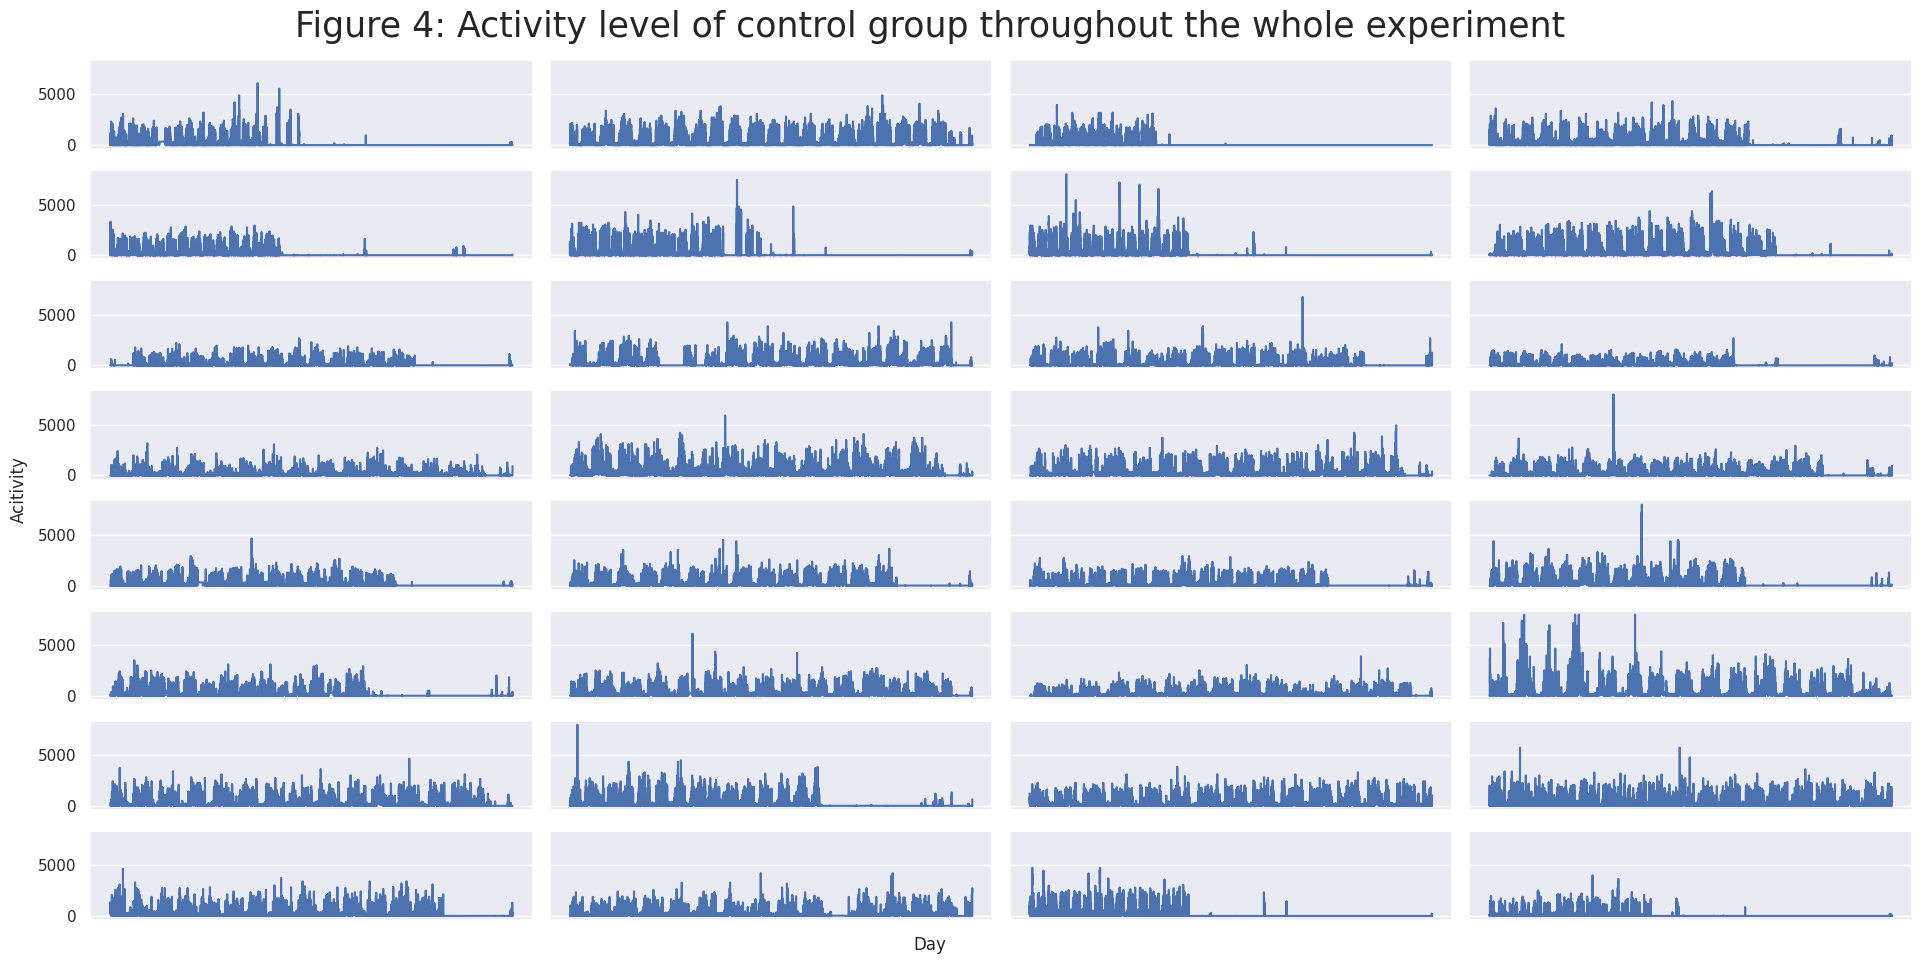

In [ ]:
nrows = 8
ncols = 4 
fig, axes = plt.subplots(nrows, ncols, figsize=(20,10), sharey=True, dpi=100)
for patient_activity_id, patient_activity_df in enumerate(control_patient_dict.values()):
    row, col = patient_activity_id//ncols, patient_activity_id % ncols
    
    #mean_activity_df = patient_activity_df.groupby("week_day").mean()
    sns.lineplot(data=patient_activity_df, x=range(len(patient_activity_df)), y="activity", ax=axes[row][col]) # x=mean_activity_df.index,

    axes[row][col].set_xticks([])
    axes[row][col].set_xlabel("")
    axes[row][col].set_ylabel("")
    #fig.autofmt_xdate()
    #plt.title("Sum of active minutes in time domain")

fig.text(0.5, 0.04, "Day", ha="center")
fig.text(0.04, 0.5, "Acitivity", va="center", rotation="vertical")
fig.suptitle("Figure 4: Activity level of control group throughout the whole experiment", size=25)
fig.tight_layout()
fig.subplots_adjust(top=0.93, bottom=0.07, left=0.08)
fig.show()

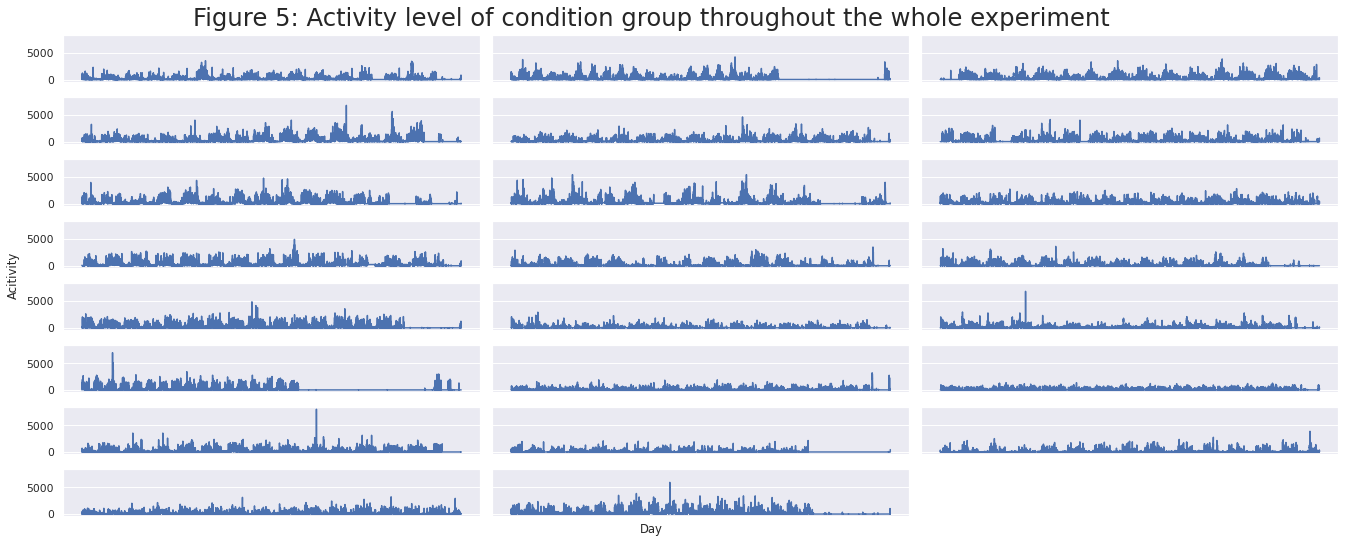

In [ ]:
nrows = 8
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8), sharey=True, dpi=70)
for patient_activity_id, patient_activity_df in enumerate(condition_patient_dict.values()):
    row, col = patient_activity_id//ncols, patient_activity_id % ncols
    # mean_activity_df = patient_activity_df.groupby("date").mean()
    # patient_activity_df, x=range(len(patient_activity_df))
    # sns.lineplot(data=mean_activity_df, x=mean_activity_df.index, y="activity", ax=axes[row][col])

    sns.lineplot(data=patient_activity_df, x=range(len(patient_activity_df)), y="activity", ax=axes[row][col])

    axes[row][col].set_xticks([])
    axes[row][col].set_xlabel("")
    axes[row][col].set_ylabel("")

axes[-1, -1].axis('off')
fig.text(0.5, 0.04, "Day", ha="center")
fig.text(0.04, 0.5, "Acitivity", va="center", rotation="vertical")
fig.suptitle("Figure 5: Activity level of condition group throughout the whole experiment", size=25)
fig.tight_layout()
fig.subplots_adjust(top=0.93, bottom=0.07, left=0.08)
fig.show()

Obvservation on subject level: very noise

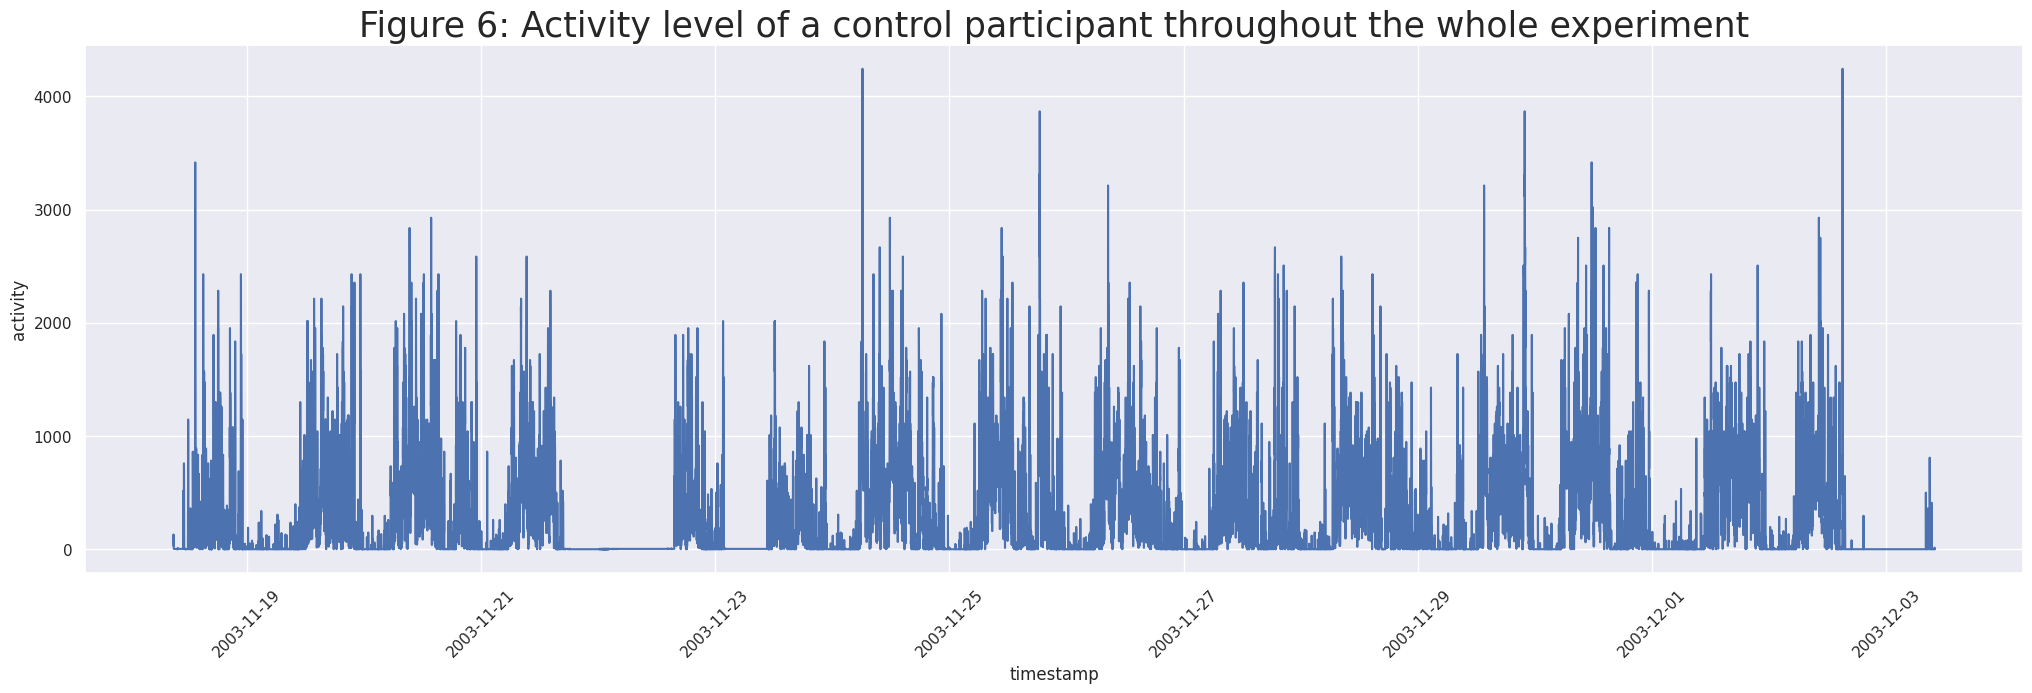

In [ ]:
plt.figure(figsize=(25, 7), dpi=100)
df = control_patient_dict["control_10"]
sns.lineplot(data=df, x="timestamp", y="activity")
plt.xticks(rotation = 45)
plt.title("Figure 6: Activity level of a control participant throughout the whole experiment", size=25)
plt.show()

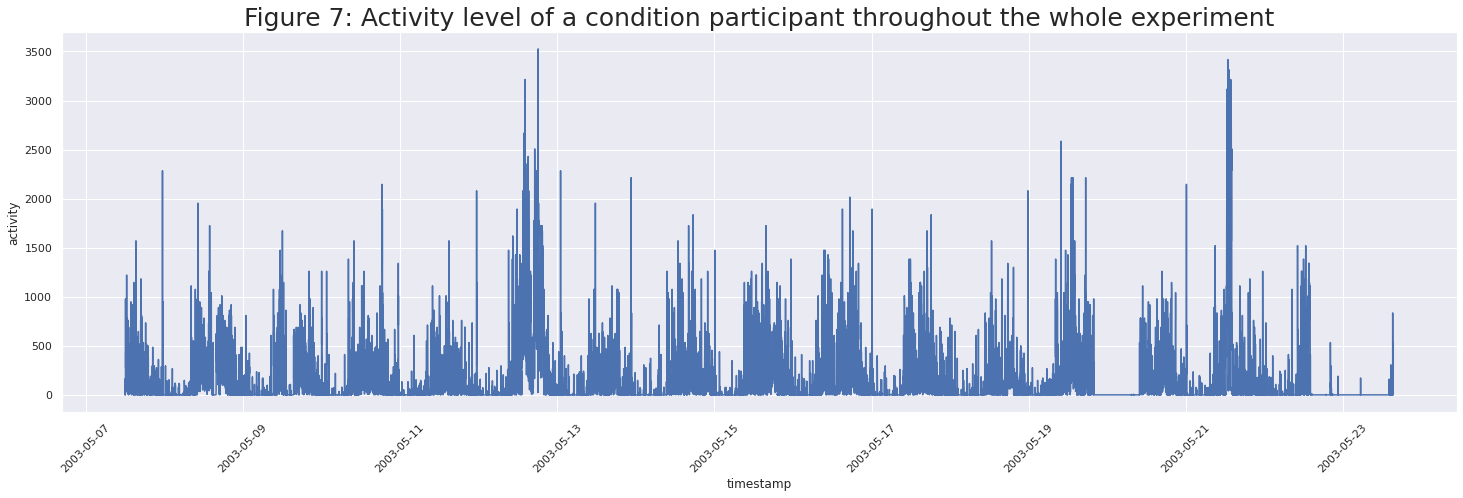

In [ ]:
plt.figure(figsize=(25, 7))
df = condition_patient_dict["condition_1"]
sns.lineplot(data=df, x="timestamp", y="activity")
plt.xticks(rotation = 45)
plt.title("Figure 7: Activity level of a condition participant throughout the whole experiment", size=25)
plt.show()

According to [https://bmcresnotes.biomedcentral.com/articles/10.1186/1756-0500-3-149], the motor activity was significantly lower in patients with depression (187 ± 84, p < 0.001), compared to controls (286 ± 80).

We compare the distribution of activity (across all time of the day, days of the week, and patients)

In [ ]:
all_patients = pd.concat([patient_activity for patient_activity in control_patient_dict.values()], axis=0)

In [ ]:
mean_control_patient_wise = [patient_activity["activity"].mean() for patient_activity in control_patient_dict.values()]
mean_condition_patient_wise = [patient_activity["activity"].mean() for patient_activity in condition_patient_dict.values()]

<Figure size 2400x840 with 0 Axes>

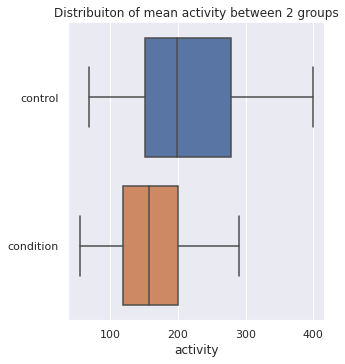

In [ ]:
fig = plt.figure(figsize=(20,7), dpi=120)
mean_patient_wise_df = pd.DataFrame(
    {
        "activity": mean_control_patient_wise + mean_condition_patient_wise,
        "cohort": ["control"]*len(mean_control_patient_wise) + ["condition"]*len(mean_condition_patient_wise)
     }
)
sns.catplot(data=mean_patient_wise_df, x="activity", y="cohort", kind="box")
plt.ylabel("")
plt.title("Distribuiton of mean activity between 2 groups")
plt.show()

In [ ]:
control_activity_summary = pd.concat(
    [patient_activity_df["activity"].describe() 
    for patient_activity_df in control_patient_dict.values()],
    axis=1
).set_axis(
    range(1, len(control_patient_dict)+1),
    axis=1
)
condition_activity_summary = pd.concat(
    [patient_activity_df["activity"].describe() 
    for patient_activity_df in condition_patient_dict.values()],
    axis=1
).set_axis(
    range(1, len(condition_patient_dict)+1),
    axis=1
)

activity_sum_df = pd.DataFrame({"control": control_activity_summary.mean(axis=1), "condition": condition_activity_summary.mean(axis=1)})
activity_sum_df

,control,condition
count,31874.687500,23987.652174
mean,208.653123,163.719349
std,369.267035,300.618905
min,0.000000,0.130435
25%,0.656250,0.391304
50%,36.593750,18.173913
75%,259.843750,198.652174
max,5136.750000,4413.608696


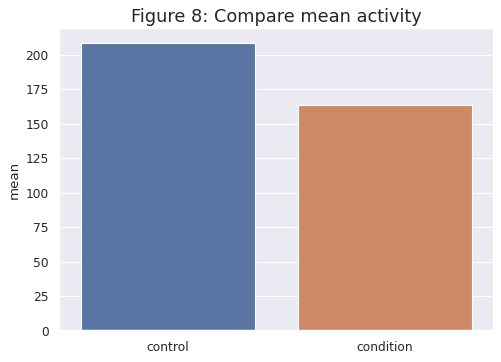

In [ ]:
activity_sum_df_compare = activity_sum_df.T.reset_index()
plt.figure(figsize=(7, 5), dpi=80)
sns.barplot(data=activity_sum_df_compare, x="index", y="mean")
plt.title("Figure 8: Compare mean activity", size=16)
plt.xlabel("")
plt.show()

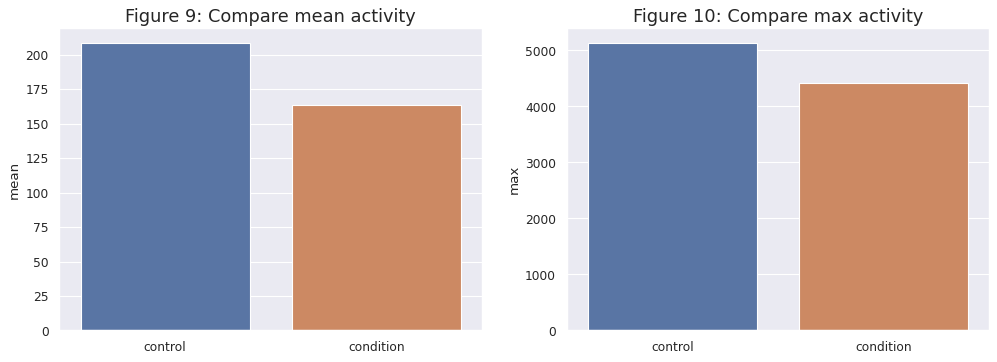

In [ ]:
fig, (mean_ax, max_ax) = plt.subplots(1, 2, figsize=(15, 5), dpi=80, sharex=True)
sns.barplot(data=activity_sum_df_compare, x="index", y="mean", ax=mean_ax)
mean_ax.set_title("Figure 9: Compare mean activity", size=16)
mean_ax.set_xlabel("")

sns.barplot(data=activity_sum_df_compare, x="index", y="max", ax=max_ax)
max_ax.set_title("Figure 10: Compare max activity", size=16)
max_ax.set_xlabel("")
plt.show()

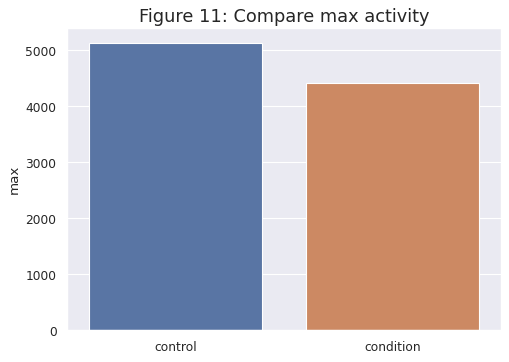

In [ ]:
plt.figure(figsize=(7, 5), dpi=80)
sns.barplot(data=activity_sum_df_compare, x="index", y="max")
plt.title("Figure 11: Compare max activity", size=16)
plt.xlabel("")
plt.show()

We visualize the relative activity level (control vs condition group) across weekdays and hours of the day to see how it changes across time. But in order to see the change for 

In [ ]:
def group_activity_level_by_hour_day(group_dict):
    avg_mean_activity_hour_day_list = []
    for patient, patient_activity in group_dict.items():
        # Get the activity by hour and day
        activity_by_hour = patient_activity.groupby(["date", "hour"]).sum()
        activity_by_hour_pivot = pd.pivot_table(activity_by_hour, index="date", columns="hour", values="activity")
        activity_by_hour_pivot['weekday'] = pd.to_datetime(activity_by_hour_pivot.index).day_name()
        mean_activity_hour_day = activity_by_hour_pivot.groupby("weekday").mean()
        mean_activity_hour_day = mean_activity_hour_day.loc[['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], :]

        # Min-max scaler for each participant
        min_activity = mean_activity_hour_day.min().min()
        max_activity = mean_activity_hour_day.max().max()
        minmax_mean_activity_hour_day = (mean_activity_hour_day - min_activity)/(max_activity - min_activity)

        # average by the number of participants
        avg_mean_activity_hour_day_list.append(minmax_mean_activity_hour_day/len(group_dict))

    return sum(avg_mean_activity_hour_day_list)

control_activity_level_by_hour_day = group_activity_level_by_hour_day(control_patient_dict)
condition_activity_level_by_hour_day = group_activity_level_by_hour_day(condition_patient_dict)

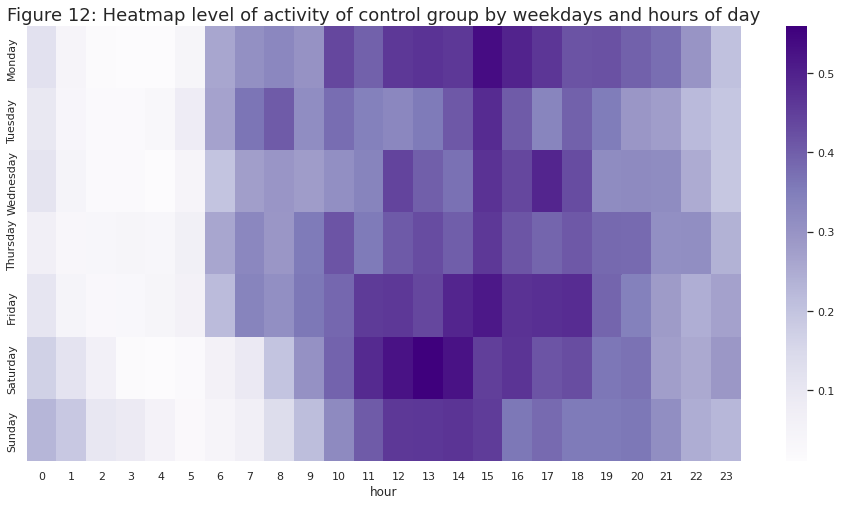

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(data=control_activity_level_by_hour_day, cmap="Purples")
plt.title("Figure 12: Heatmap level of activity of control group by weekdays and hours of day", size=18)
plt.ylabel("")
plt.show()

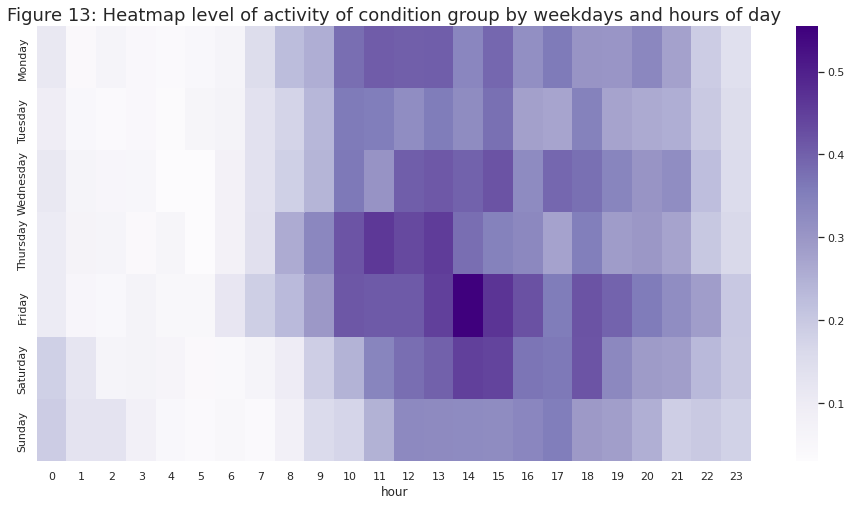

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(data=condition_activity_level_by_hour_day, cmap="Purples")
plt.title("Figure 13: Heatmap level of activity of condition group by weekdays and hours of day", size=18)
plt.ylabel("")
plt.show()

#### Individual level

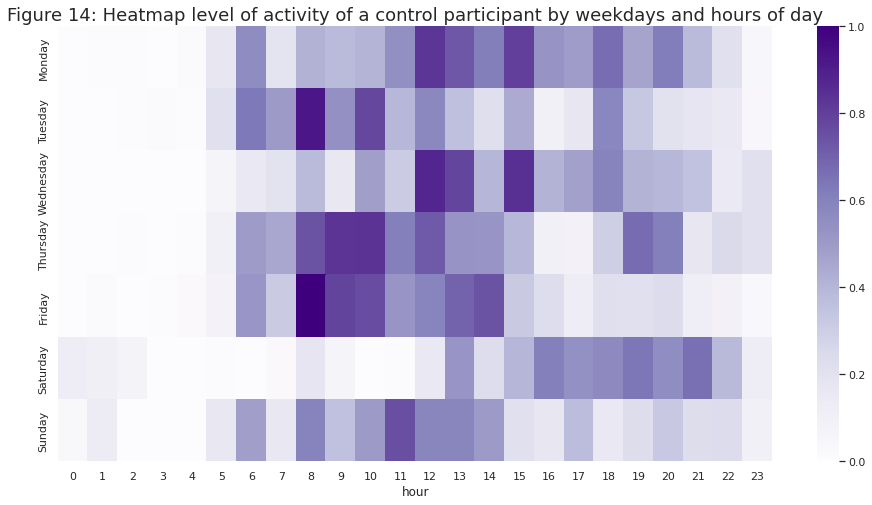

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(
    data=group_activity_level_by_hour_day({"control_10": control_patient_dict["control_10"]}),
    cmap="Purples"
)
plt.title("Figure 14: Heatmap level of activity of a control participant by weekdays and hours of day", size=18)
plt.ylabel("")
plt.show()

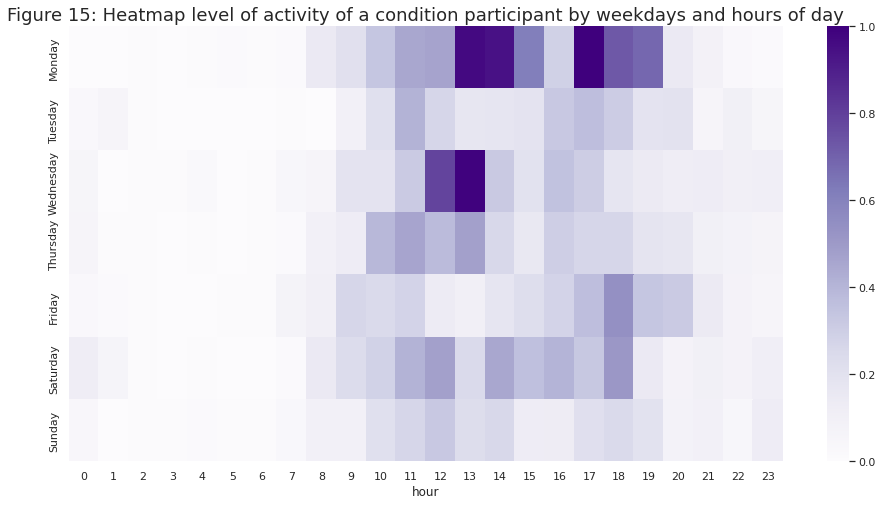

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(
    data=group_activity_level_by_hour_day({"condition_1": condition_patient_dict["condition_1"]}),
    cmap="Purples"
)
plt.title("Figure 15: Heatmap level of activity of a condition participant by weekdays and hours of day", size=18)
plt.ylabel("")
plt.show()

# 3. Modelling
## Understanding sleep pattern analysis of depressed vs non-depressed participants



## Clustering/Classification

In [ ]:
condition_score_df["madrs_progression"] = condition_score_df["start_madrs"] - condition_score_df["final_madrs"]

In [ ]:
MADRS1 = np.array(condition_score_df["start_madrs"])
MADRS2 = np.array(condition_score_df["final_madrs"])
MADRS = np.vstack((MADRS1, MADRS2))

Time Series Components:
*   Systematic: Components of the time series that have consistency or recurrence and can be described and modeled.
*   Non-Systematic: Components of the time series that cannot be directly modeled.
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.


These components are defined as follows:
*   Level: The average value in the series.
*   Trend: The increasing or decreasing value in the series.
*   Seasonality: The repeating short-term cycle in the series.
*   Noise: The random variation in the series.